Processed training data shape: (1460, 258)
Processed test data shape: (1459, 257)


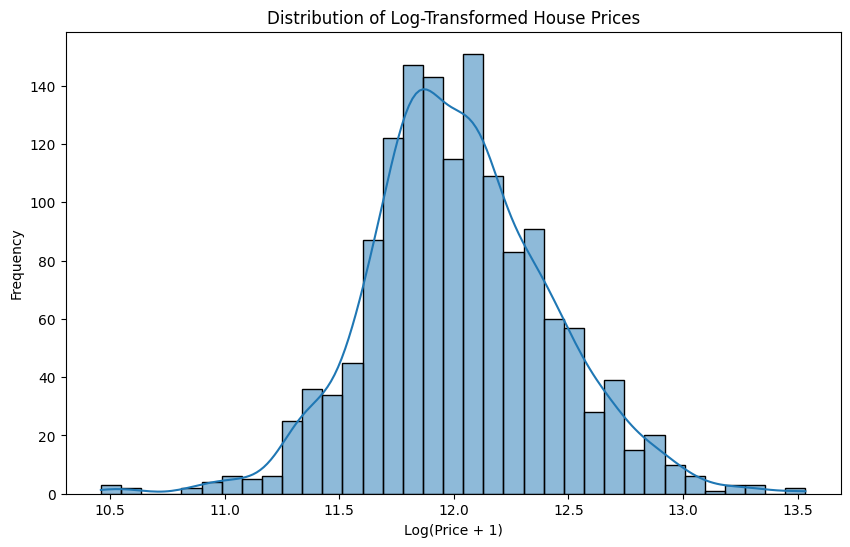

In [1]:
# For cleaning data and feature engineering

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')  # If using Kaggle data

# Combine datasets for preprocessing (we'll separate them later)
# Save the test IDs for submission
test_ids = test_data['Id']
train_data['is_train'] = 1
test_data['is_train'] = 0
test_data['SalePrice'] = np.nan  # Add placeholder for the target
combined = pd.concat([train_data, test_data], axis=0)

# 1. Handle missing values
# For numerical features: fill with median
numerical_features = combined.select_dtypes(include=['int64', 'float64']).columns
for feature in numerical_features:
    if combined[feature].isnull().sum() > 0:
        # For features with meaningful 0 values (like basements), fill with 0
        if "Bsmt" in feature or "Garage" in feature:
            combined[feature] = combined[feature].fillna(0)
        else:
            combined[feature] = combined[feature].fillna(combined[feature].median())

# For categorical features: fill with 'None' or most common value
categorical_features = combined.select_dtypes(include=['object']).columns
for feature in categorical_features:
    if combined[feature].isnull().sum() > 0:
        # For features where missing likely means absence
        if "Bsmt" in feature or "Garage" in feature or "Alley" in feature:
            combined[feature] = combined[feature].fillna('None')
        else:
            combined[feature] = combined[feature].fillna(combined[feature].mode()[0])

# 2. Transform skewed numerical features
# SalePrice and many numerical features are right-skewed
skewed_features = combined.select_dtypes(include=['int64', 'float64'])
skewed_features = skewed_features.drop(['Id', 'is_train'], axis=1)

# Calculate skewness
skewness = skewed_features.apply(lambda x: x.skew())
skewed = skewness[abs(skewness) > 0.5].index

# Apply log transformation to skewed features
for feature in skewed:
    if feature != 'SalePrice':  # Don't transform test SalePrice (it's NaN)
        combined[feature] = np.log1p(combined[feature])

# Transform target variable (SalePrice)
combined['SalePrice'] = np.log1p(combined['SalePrice'])

# 3. Encode categorical features
# One-hot encode all categorical features
combined = pd.get_dummies(combined, drop_first=True)

# 4. Create some feature interactions
# Example: Total square footage
combined['TotalSF'] = combined['1stFlrSF'] + combined['2ndFlrSF'] + combined['TotalBsmtSF']

# run a `copy` to address the fact that the DataFrame is highly fragmented (this is a warning in notebook 04)
combined = combined.copy()

# 5. Split back into training and test sets
train = combined[combined['is_train'] == 1].drop('is_train', axis=1)
test = combined[combined['is_train'] == 0].drop(['is_train', 'SalePrice'], axis=1)

# Save processed data for modeling
train.to_csv('data/processed_train.csv', index=False)
test.to_csv('data/processed_test.csv', index=False)

print(f"Processed training data shape: {train.shape}")
print(f"Processed test data shape: {test.shape}")

# Visualize transformed target variable
plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True)
plt.title('Distribution of Log-Transformed House Prices')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.show()